In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
from matplotlib.pyplot import figure
from kmean import run_kmean_mhho, plot_points

# Reading data

In [2]:
dataframe = pd.read_csv("D:\\Logistic_code\\code\\vrp\\clustering\\fuzzy_c_mean\\data2.csv")

In [3]:
data = dataframe.to_numpy()

In [6]:
data

array([[ 500,  500,    0],
       [ 740,  442,    8],
       [ 261,  710,   10],
       [ 578,  522,    8],
       [ 482,  914,    5],
       [ 628,  644,   10],
       [ 551,  651,    5],
       [ 828,   54,    9],
       [ 541,  270,   10],
       [ 450, 1000,    6],
       [ 521,  127,    5],
       [ 738,  809,   10],
       [ 323,  289,    5],
       [ 803,  214,    9],
       [ 556,  488,   10],
       [ 758,  937,    7],
       [ 875,  326,    9],
       [ 113,  509,    7],
       [ 491,  726,    8],
       [ 415,  355,    5],
       [ 946,  632,    8],
       [ 136,  120,   10],
       [ 117,  971,    6],
       [ 817,  246,    8],
       [ 491,  845,    7],
       [ 454,  801,    6],
       [ 676,  995,    7],
       [ 145,  557,    5],
       [ 166,  494,   10],
       [ 977,  318,   10],
       [ 363,  711,    5],
       [ 164,  501,    7],
       [ 833,  501,    5],
       [ 444,  958,   10],
       [ 828,  672,    6],
       [ 714,   57,    7],
       [  51,  676,    9],
 

## Full impl

In [7]:
def Levy(dim):
    beta = 1.5
    sigma = (math.gamma(1 + beta) * math.sin(math.pi * beta / 2) / (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta) 
    u= 0.01 * np.random.randn(dim) * sigma
    v = np.random.randn(dim)
    zz = np.power(np.absolute(v), (1 / beta))
    step = np.divide(u, zz)
    return step

In [8]:
### CALCULATE DISTANCE MATRIX ###
def calculate_distance_matrix(centroids, points):
    """
        centroids: shape(k,2)
        points: shape(m, 2)

        output : shape (m, k)
    """
    centroids_ext = np.expand_dims(centroids, axis=0)
    points_ext = np.expand_dims(points, axis=1)
    return np.sum((centroids_ext - points_ext) ** 2, axis=2) ** 0.5

def find_cluster(centroids, data, vehicle_cap, p, c):
    distance_matrix = calculate_distance_matrix(centroids, data[:, :2])
    new_centroids = np.zeros((centroids.shape[0], 5))
    for i in range(centroids.shape[0]):
        new_centroids[i, 0] = i 
    new_centroids[:, 1:3] = centroids
    
    distance_data = np.append(data.copy(), np.zeros((data.shape[0], 2)), axis = 1) # [x, y, demand, centroid_index, distance_to_centroid]
    capacity_violation = 0
    ## Assign to nearest cluster and update centroid capacity
    for i in range(data.shape[0]):
        # print(f"process data {i} : {data[i, :]}")
        centroid_distance = distance_matrix[i, :]
        nearest_centroid_order = np.argsort(centroid_distance)
        is_violated = True
        for nearest_centroid_idx in nearest_centroid_order:
            ## Check adding customer demand exceeds vehicle capacity 
            if (new_centroids[nearest_centroid_idx, 3] + data[i, 2]) < vehicle_cap:
                # print(f"data {i} is not violate. Insert to centroid {nearest_centroid_idx}")
                new_centroids[nearest_centroid_idx, 3] = new_centroids[nearest_centroid_idx, 3] + data[i, 2]
                is_violated = False
                distance_data[i, 3] = nearest_centroid_idx
                distance_data[i, 4] = centroid_distance[nearest_centroid_idx]
                break
        if is_violated: # If all capacity is violate, assign to cluster have minimum violation (minimum current capacity)
            min_cap_centroid_idx = np.argmin(new_centroids[:, 3], axis = 0)
            new_centroids[min_cap_centroid_idx, 3] = new_centroids[min_cap_centroid_idx, 3] + data[i, 2]
            capacity_violation = capacity_violation + new_centroids[min_cap_centroid_idx, 3] - vehicle_cap
            distance_data[i, 3] = min_cap_centroid_idx
            distance_data[i, 4] = centroid_distance[nearest_centroid_idx]
            # print(f"data {i} is violated. Insert to neareste centroid with minimum violation {min_cap_centroid_idx}")
    fitness = calculate_fitness(distance_data, capacity_violation, p, c)
    return new_centroids, distance_data, capacity_violation, fitness

def calculate_fitness(distance_data, capacity_violation, p, c):
    return np.sum(distance_data[:,4] ** 2) + p * capacity_violation ** c

In [ ]:
cen = np.array([[0, 3 , 4, 0, 0] , [1, 5, 7, 0, 0] , [2, 8, 2, 0, 0]])
data_point = np.array([[5 , 8, 3] , [10 , 72, 5] , [12 , 89, 10] , [4 , 0, 23], [9 , 0, 17]])
t = calculate_distance_matrix(cen[:, 1:3], data_point[:,:2])
arr = np.argmin(t, axis=1)
new_cen, distance_data, cap_violate, fitness = find_cluster(cen[:,1:3], data_point, 12, 1500, 2)

In [9]:
## Number of cluster ##
num_cluster = 13 
## Violate capacity ##
vehicle_capacity = 66
## Penalty number
p = 1500
c = 2
## Data matrix ##
data_matrix = data[:,:2] 
## Demanbd vector ##
demand_vector = data[:,2:]  
## number of data ##
n = data.shape[0]
## Define centroids ##
centroids = np.zeros((num_cluster, 5)) ## Centroid matrix [no.Cluster, x, y, current capacity, total distance]
# distance = np.zeros(n, num_cluster + 2)
## Maximum iteration ##
max_iter = 500
convergence_curve = np.zeros(max_iter)
## Lower bound ##
lb = np.array([np.min(data_matrix[:,0]), np.min(data_matrix[:,1])])
# lb = 0
## Upper bound ##
ub = np.array([np.max(data_matrix[:,0]), np.max(data_matrix[:,1])])
# ub = 100
## Fitness matrix ##

### Define no. cluster ##
for i in range(num_cluster):
    centroids[i, 0] = i 

## Number of search agent ##
SearchAgents_no = 30
dim = 2
t = 0
# Initialize the locations of Harris' hawks (position of search agents)
X = np.random.uniform(0, 1, (SearchAgents_no, num_cluster, dim)) * (ub - lb) + lb
# Initialize the location and Energy of the rabbit
Rabbit_Location = np.zeros((num_cluster, dim))
# Centroid_Location = 
Rabbit_Energy = float("inf")  #change this to -inf for maximization problems
## Fitness value ##
fitness_values = np.zeros(SearchAgents_no)

while t < max_iter:
    print(f"Iteration {t}")
    for i in range(0, SearchAgents_no):
        # Check boundaries
        X[i, :] = np.clip(X[i, :], lb, ub)
        # Fitness of location
        new_centroids, distance_data, capacity_violation, fitness = find_cluster(X[i, :].copy(), data, vehicle_capacity, p, c)
        
        # Update the location of Rabbit
        if fitness < Rabbit_Energy: # Change this to > for maximization problem
            print(f"Update fitness at {i}")
            Rabbit_Energy = fitness 
            Rabbit_Location = X[i, :].copy() 
            centroids = new_centroids
    E1 = 2 * (1 - (t / max_iter)) # factor to show the decreaing energy of rabbit    
    
    # Update the location of Harris' hawks 
    for m in range(0, SearchAgents_no):
        E0 = 2 * random.random() - 1;  # -1<E0<1
        Escaping_Energy = E1 * (E0)  # escaping energy of rabbit Eq. (3) in the paper

        # for u in range(num_cluster):
        # -------- Exploration phase Eq. (1) in paper -------------------
        # m = i * num_cluster + u
        # m = i
        if abs(Escaping_Energy) >= 1:
            #Harris' hawks perch randomly based on 2 strategy:
            q = random.random()
            rand_Hawk_index = math.floor(SearchAgents_no * random.random())
            X_rand = X[rand_Hawk_index, :]
            if q < 0.5:
                # perch based on other family members
                X[m,:] = X_rand - random.random() * abs(X_rand - 2 * random.random() * X[m,:])

            elif q >= 0.5:
                #perch on a random tall tree (random site inside group's home range)
                X[m,:] = (Rabbit_Location - X.mean(axis=0)) - random.random() * ((ub - lb) * random.random() + lb)

        # -------- Exploitation phase -------------------
        elif abs(Escaping_Energy) < 1:
            #Attacking the rabbit using 4 strategies regarding the behavior of the rabbit

            #phase 1: ----- surprise pounce (seven kills) ----------
            #surprise pounce (seven kills): multiple, short rapid dives by different hawks

            r = random.random() # probablity of each event
            
            if r >= 0.5 and abs(Escaping_Energy) < 0.5: # Hard besiege Eq. (6) in paper
                X[m,:] = (Rabbit_Location) - Escaping_Energy * abs(Rabbit_Location - X[m,:])

            if r >= 0.5 and abs(Escaping_Energy) >= 0.5:  # Soft besiege Eq. (4) in paper
                Jump_strength = 2 * (1 - random.random()); # random jump strength of the rabbit
                X[m,:] = (Rabbit_Location - X[m,:]) - Escaping_Energy * abs(Jump_strength * Rabbit_Location - X[m,:])
            
            #phase 2: --------performing team rapid dives (leapfrog movements)----------

            if r < 0.5 and abs(Escaping_Energy) >= 0.5: # Soft besiege Eq. (10) in paper
                #rabbit try to escape by many zigzag deceptive motions
                Jump_strength = 2 * (1 - random.random())
                X1 = Rabbit_Location - Escaping_Energy * abs(Jump_strength * Rabbit_Location - X[m,:])
                
                new_fitness_X1 = find_cluster(X1, data, vehicle_capacity, p, c)[3]
                # if objf(X1) < fitness: # improved move?
                if new_fitness_X1 < fitness: # improved move?
                    X[m,:] = X1.copy()
                else: # hawks perform levy-based short rapid dives around the rabbit
                    X2 = Rabbit_Location - Escaping_Energy * abs(Jump_strength * Rabbit_Location - X[m,:]) + np.multiply(np.random.randn(dim), Levy(dim))
                    new_fitness_X2 = find_cluster(X2, data, vehicle_capacity, p, c)[3]
                    # if objf(X2) < fitness:
                    if new_fitness_X2 < fitness:
                        X[m,:] = X2.copy()
            if r < 0.5 and abs(Escaping_Energy) < 0.5:   # Hard besiege Eq. (11) in paper
                    Jump_strength = 2 * (1 - random.random())
                    X1 = Rabbit_Location - Escaping_Energy * abs(Jump_strength * Rabbit_Location - X.mean(0))

                    new_fitness_X1 = find_cluster(X1, data, vehicle_capacity, p, c)[3]
                    # if objf(X1) < fitness: # improved move?
                    if new_fitness_X1 < fitness: # improved move?
                        X[m,:] = X1.copy()
                    else: # Perform levy-based short rapid dives around the rabbit
                        X2 = Rabbit_Location - Escaping_Energy * abs(Jump_strength * Rabbit_Location - X.mean(0)) + np.multiply(np.random.randn(dim), Levy(dim))
                        new_fitness_X2 = find_cluster(X2, data, vehicle_capacity, p, c)[3]
                        # if objf(X2) < fitness:
                        if new_fitness_X2 < fitness:
                            X[m,:] = X2.copy() 

    convergence_curve[t] = Rabbit_Energy
    if (t % 1 == 0):
            print(['At iteration '+ str(t)+ ' the best fitness is '+ str(Rabbit_Energy)])
    t = t + 1
          

Iteration 0
Update fitness at 0
Update fitness at 1
Update fitness at 3
Update fitness at 11
Update fitness at 12
['At iteration 0 the best fitness is 4444131.425365002']
Iteration 1
['At iteration 1 the best fitness is 4444131.425365002']
Iteration 2
Update fitness at 5
['At iteration 2 the best fitness is 3672649.9904701104']
Iteration 3
['At iteration 3 the best fitness is 3672649.9904701104']
Iteration 4
['At iteration 4 the best fitness is 3672649.9904701104']
Iteration 5
Update fitness at 20
['At iteration 5 the best fitness is 3513001.464223707']
Iteration 6
['At iteration 6 the best fitness is 3513001.464223707']
Iteration 7
['At iteration 7 the best fitness is 3513001.464223707']
Iteration 8
['At iteration 8 the best fitness is 3513001.464223707']
Iteration 9
['At iteration 9 the best fitness is 3513001.464223707']
Iteration 10
['At iteration 10 the best fitness is 3513001.464223707']
Iteration 11
Update fitness at 27
['At iteration 11 the best fitness is 3371287.6529273815']


In [10]:
def plot_points(centroid : np.ndarray, distance_data : np.ndarray):
    figure(figsize=(14, 12), dpi=80)
    cluster_color = np.random.rand(centroid.shape[0], 3)
    # Plot point  
    for i in range(distance_data.shape[0]):
        data = distance_data[i]
        # print(cluster_color[data[3]])
        plt.scatter(data[0], data[1], marker="o", c = [cluster_color[int(data[3])]])
    # Plot cluster center
    plt.scatter(centroid[:,1], centroid[:,2], marker="x", c=[[0,0,0]])



In [11]:
centroids

array([[  0.        , 117.30804695, 567.293372  ,  65.        ,
          0.        ],
       [  1.        , 385.14642825,  66.3158563 ,  64.        ,
          0.        ],
       [  2.        , 636.81542097, 906.46963212,  63.        ,
          0.        ],
       [  3.        , 578.63069306, 370.2316735 ,  62.        ,
          0.        ],
       [  4.        , 901.8832612 , 301.34140057,  63.        ,
          0.        ],
       [  5.        , 708.9483583 , 286.9991775 ,  65.        ,
          0.        ],
       [  6.        , 707.87333314, 514.12808842,  65.        ,
          0.        ],
       [  7.        , 879.95253712, 387.13720346,  54.        ,
          0.        ],
       [  8.        , 898.47752085, 730.68498969,  64.        ,
          0.        ],
       [  9.        ,  90.68297558, 630.02056811,  61.        ,
          0.        ],
       [ 10.        , 340.51369544, 592.5276704 ,  65.        ,
          0.        ],
       [ 11.        , 148.69696449, 901.877

In [12]:
distance_data

array([[ 500.        ,  500.        ,    0.        ,    3.        ,
         151.73189733],
       [ 740.        ,  442.        ,    8.        ,    6.        ,
          78.96065857],
       [ 261.        ,  710.        ,   10.        ,   10.        ,
         141.8505476 ],
       [ 578.        ,  522.        ,    8.        ,    6.        ,
         130.11643152],
       [ 482.        ,  914.        ,    5.        ,    2.        ,
         155.00261818],
       [ 628.        ,  644.        ,   10.        ,    6.        ,
         152.4674356 ],
       [ 551.        ,  651.        ,    5.        ,    6.        ,
         208.19158234],
       [ 828.        ,   54.        ,    9.        ,    4.        ,
         258.14432047],
       [ 541.        ,  270.        ,   10.        ,    3.        ,
         107.06673434],
       [ 450.        , 1000.        ,    6.        ,    2.        ,
         208.92202389],
       [ 521.        ,  127.        ,    5.        ,    1.        ,
         148

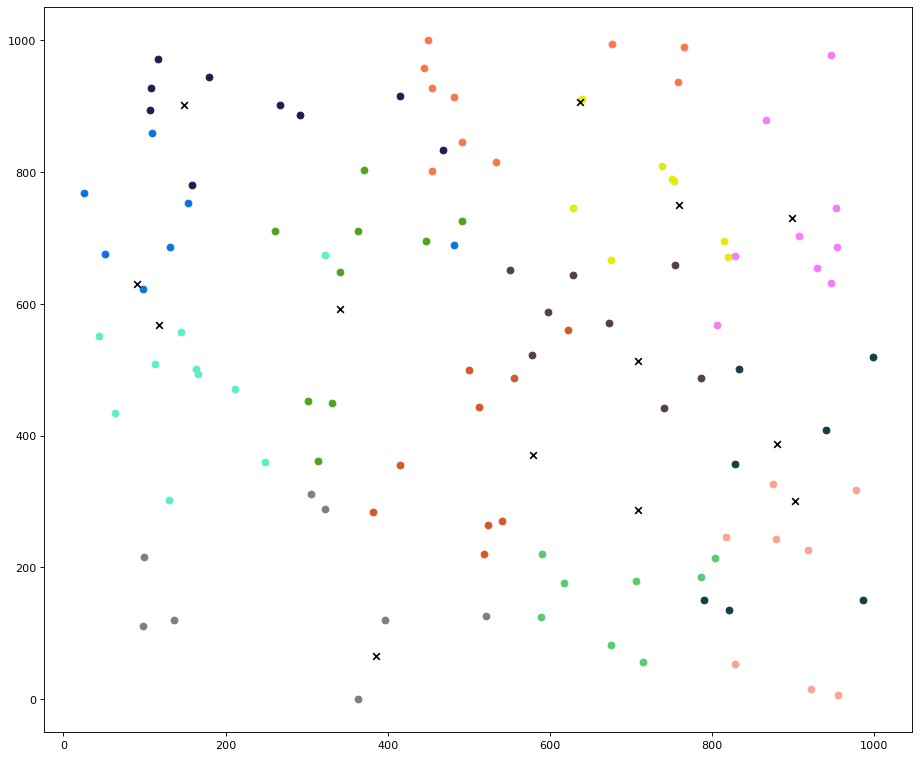

In [13]:
plot_points(centroids, distance_data)

## Library testing

In [4]:
centroids, distance_data = run_kmean_mhho(data)

Iteration 0
Update fitness at 0
Update fitness at 1
Update fitness at 7
Update fitness at 9
Update fitness at 11
['At iteration 0 the best fitness is 6298947.491742465']
Iteration 1
Update fitness at 19
['At iteration 1 the best fitness is 5587483.907953217']
Iteration 2
Update fitness at 26
['At iteration 2 the best fitness is 4608424.17304716']
Iteration 3
['At iteration 3 the best fitness is 4608424.17304716']
Iteration 4
Update fitness at 7
['At iteration 4 the best fitness is 4488350.213509712']
Iteration 5
Update fitness at 9
['At iteration 5 the best fitness is 4408036.297659863']
Iteration 6
['At iteration 6 the best fitness is 4408036.297659863']
Iteration 7
['At iteration 7 the best fitness is 4408036.297659863']
Iteration 8
['At iteration 8 the best fitness is 4408036.297659863']
Iteration 9
['At iteration 9 the best fitness is 4408036.297659863']
Iteration 10
['At iteration 10 the best fitness is 4408036.297659863']
Iteration 11
['At iteration 11 the best fitness is 4408036

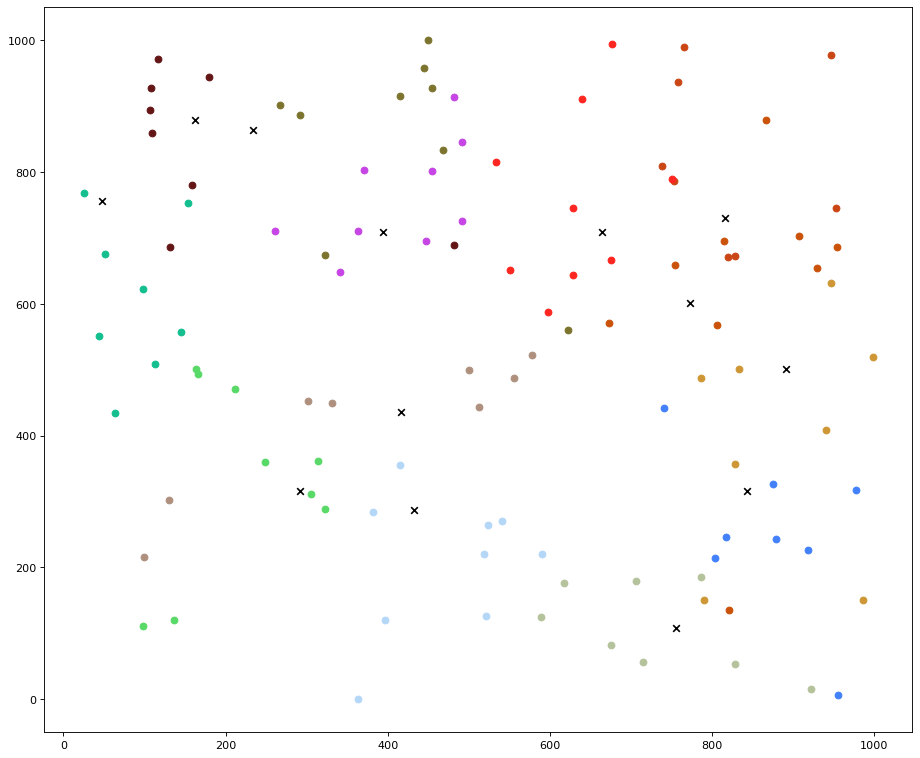

In [5]:
plot_points(centroids, distance_data)

In [6]:
distance_data

array([[ 500.        ,  500.        ,    0.        ,    6.        ,
         105.9387346 ],
       [ 740.        ,  442.        ,    8.        ,    0.        ,
         161.69321537],
       [ 261.        ,  710.        ,   10.        ,   11.        ,
         132.61370684],
       [ 578.        ,  522.        ,    8.        ,    6.        ,
         183.8197005 ],
       [ 482.        ,  914.        ,    5.        ,   11.        ,
         223.51075013],
       [ 628.        ,  644.        ,   10.        ,    8.        ,
          74.43055896],
       [ 551.        ,  651.        ,    5.        ,    8.        ,
         126.62402975],
       [ 828.        ,   54.        ,    9.        ,   10.        ,
          90.8855027 ],
       [ 541.        ,  270.        ,   10.        ,    9.        ,
         109.84899496],
       [ 450.        , 1000.        ,    6.        ,    2.        ,
         255.55736443],
       [ 521.        ,  127.        ,    5.        ,    9.        ,
         183